<img src = 'https://storage.googleapis.com/kaggle-competitions/kaggle/22962/logos/header.png?t=2021-03-17-22-44-09'>
<center>
<img role="presentation" alt class="competition-header__org-thumbnail-image" src="https://storage.googleapis.com/kaggle-organizations/3774/thumbnail.jpeg">
</center>
<br>



**This Notebook helpful to anyone who is looking for and EDA.** <br>
The model training process is commented out. beacase, It takes a lot of time.<br>
If you want to training Process. I hope turn on GPU.
<br>
**This content is completely written from EDA to submission.**
<br>
# Contents
-  Import and Setup
-  load Data and species Info
-  Replace Duplicate Features
-  Whale and Dolphin barplot
-  Whale and Dolphin barplot
-  Top10 Whale & Dolphin
-  load Image and Visualization Whale & Dolphin
-  Prepare labeling and Transforms
-  Load Dataset
-  Model
-  Conclusion and Submission
-  Reference Link
<br>

**If you helpful, Don't forget upvote!**

<a id="top"></a>

<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:skyblue; border:0' role="tab" aria-controls="home">
<center>Import and Setup</center></h3>

# 1. Import and Setup

In [1]:
import os
import albumentations
import albumentations.pytorch as AT
import numpy as np
import pandas as pd
import cv2
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision
from torchvision.models import vgg16
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset
from torch.utils.data.sampler import SubsetRandomSampler
from PIL import Image
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:skyblue; border:0' role="tab" aria-controls="home">
<center>load Data and species Info</center></h3>

# 2. load Data and species Info

In [2]:
train_df = pd.read_csv('../input/happy-whale-and-dolphin/train.csv')
train_df.head()

print('Individual_ID Unique Value', train_df['individual_id'].nunique())
num_classes = train_df['individual_id'].nunique()
print()
train_df['species'].unique()

Individual_ID Unique Value 15587



array(['melon_headed_whale', 'humpback_whale', 'false_killer_whale',
       'bottlenose_dolphin', 'beluga', 'minke_whale', 'fin_whale',
       'blue_whale', 'gray_whale', 'southern_right_whale',
       'common_dolphin', 'kiler_whale', 'pilot_whale', 'dusky_dolphin',
       'killer_whale', 'long_finned_pilot_whale', 'sei_whale',
       'spinner_dolphin', 'bottlenose_dolpin', 'cuviers_beaked_whale',
       'spotted_dolphin', 'globis', 'brydes_whale', 'commersons_dolphin',
       'white_sided_dolphin', 'short_finned_pilot_whale',
       'rough_toothed_dolphin', 'pantropic_spotted_dolphin',
       'pygmy_killer_whale', 'frasiers_dolphin'], dtype=object)

**There are cases where certain values are dupliates, so you need to fix the duplicate cases.**

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:skyblue; border:0' role="tab" aria-controls="home">
<center>Replace Duplicate Features</center></h3>

# 3. Replace Duplicate Features

In [3]:
def duplicate_feature(data, species):
    for duplicate, change in species:
        data['species'] = data['species'].str.replace(duplicate, change)
        
    return data

dup_species = [['bottlenose_dolpin','bottlenose_dolphin'], ['kiler_whale','killer_whale']]
train_df = duplicate_feature(train_df, dup_species)

**We can identify sone of the speices as being dolphine and other as whales, therefore, we also observe it.**

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:skyblue; border:0' role="tab" aria-controls="home">
<center>Whale & Dolphin barplot</center></h3>

# 4. Whale and Dolphin barplot

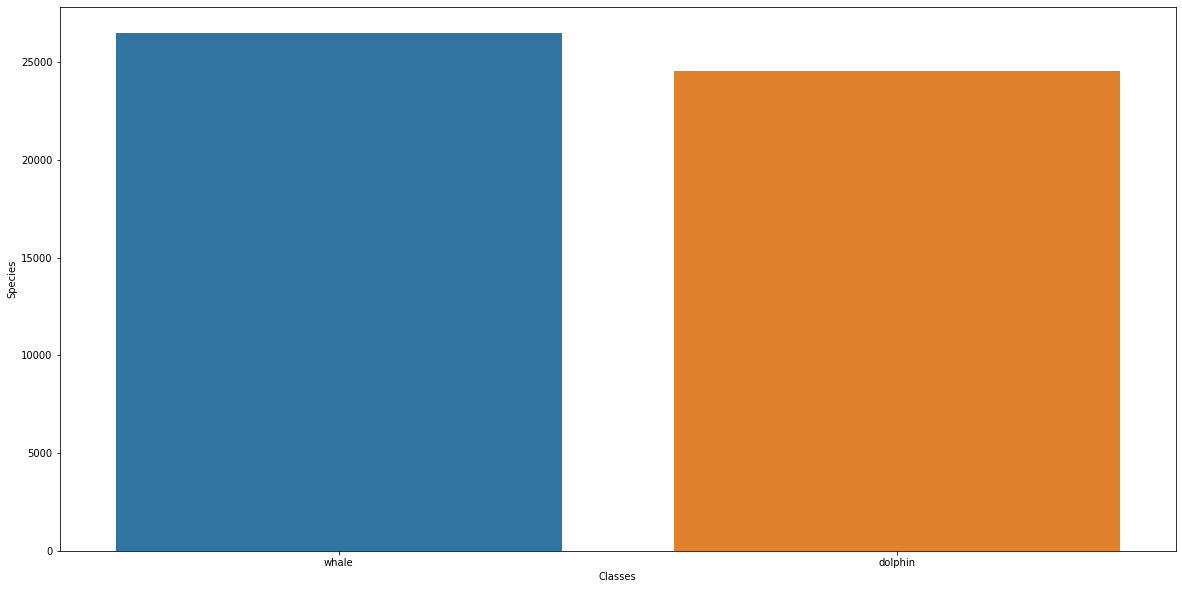

In [4]:
train_df['class'] = train_df.species.map(lambda x: 'whale' if 'whale' in x else 'dolphin')

temp = train_df['class'].value_counts()
temp_df = pd.DataFrame({'Classes':temp.index,
                        'Species':temp.values})
plt.figure(figsize = (20, 10))
sns.barplot(x = 'Classes', y = 'Species', data = temp_df)
plt.show()

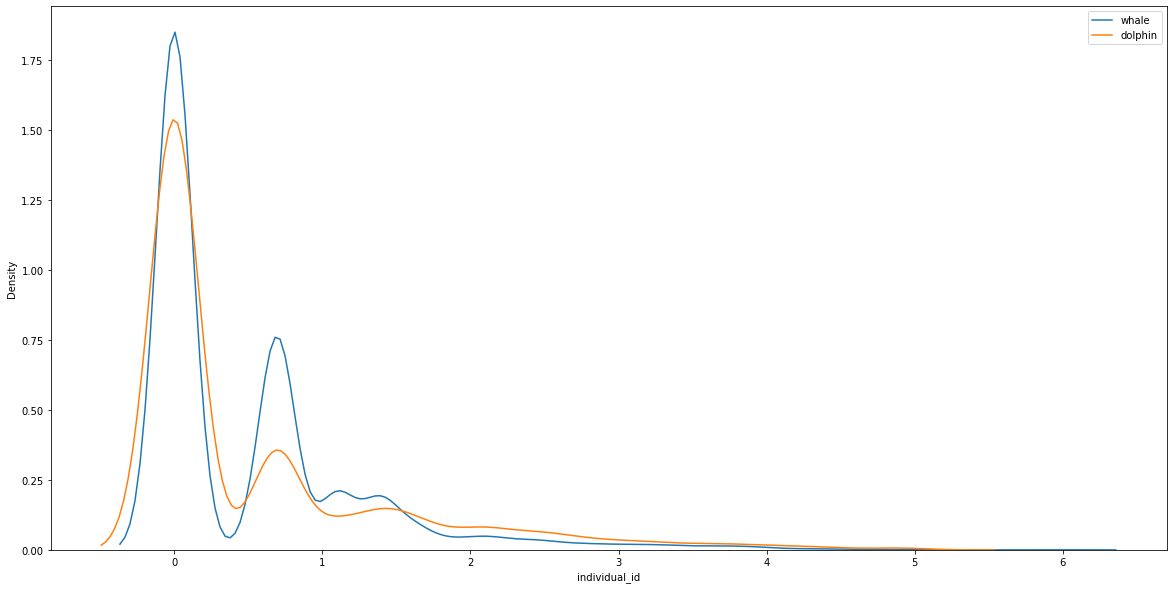

In [5]:
plt.figure(figsize = (20, 10))
sns.kdeplot(np.log(train_df.loc[train_df['class'] == 'whale']['individual_id'].value_counts()))
sns.kdeplot(np.log(train_df.loc[train_df['class'] == 'dolphin']['individual_id'].value_counts()))
plt.legend(labels = ['whale', 'dolphin'])
plt.show()

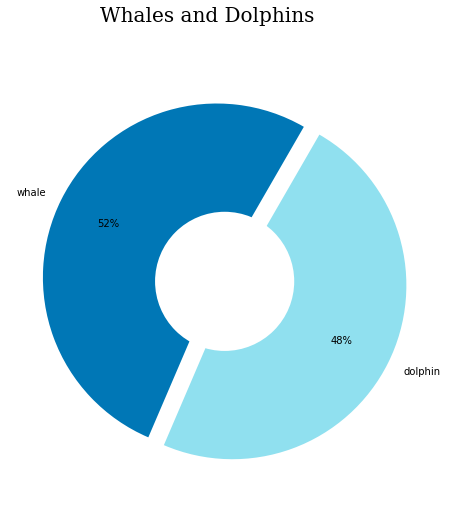

In [6]:
fig, ax  = plt.subplots(figsize=(16, 8))
fig.suptitle('Whales and Dolphins ', size = 20, font="Serif")
explode = (0.05, 0.05)
labels = list(train_df['class'].value_counts().index)
sizes = train_df['class'].value_counts().values
ax.pie(sizes, explode=explode,startangle=60, labels=labels,autopct='%1.0f%%', pctdistance=0.7, colors=["#0077b6","#90e0ef"])
ax.add_artist(plt.Circle((0,0),0.4,fc='white'))
plt.show()

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:skyblue; border:0' role="tab" aria-controls="home">
<center>Top10 Whale & Dolphin</center></h3>

# 5. Top10 Whale & Dolphin

In [7]:
print('Top 10 Whale & Dolphin')
train_df['species'].value_counts().head(10)

Top 10 Whale & Dolphin


bottlenose_dolphin    10781
beluga                 7443
humpback_whale         7392
blue_whale             4830
false_killer_whale     3326
dusky_dolphin          3139
killer_whale           2455
spinner_dolphin        1700
melon_headed_whale     1689
minke_whale            1608
Name: species, dtype: int64

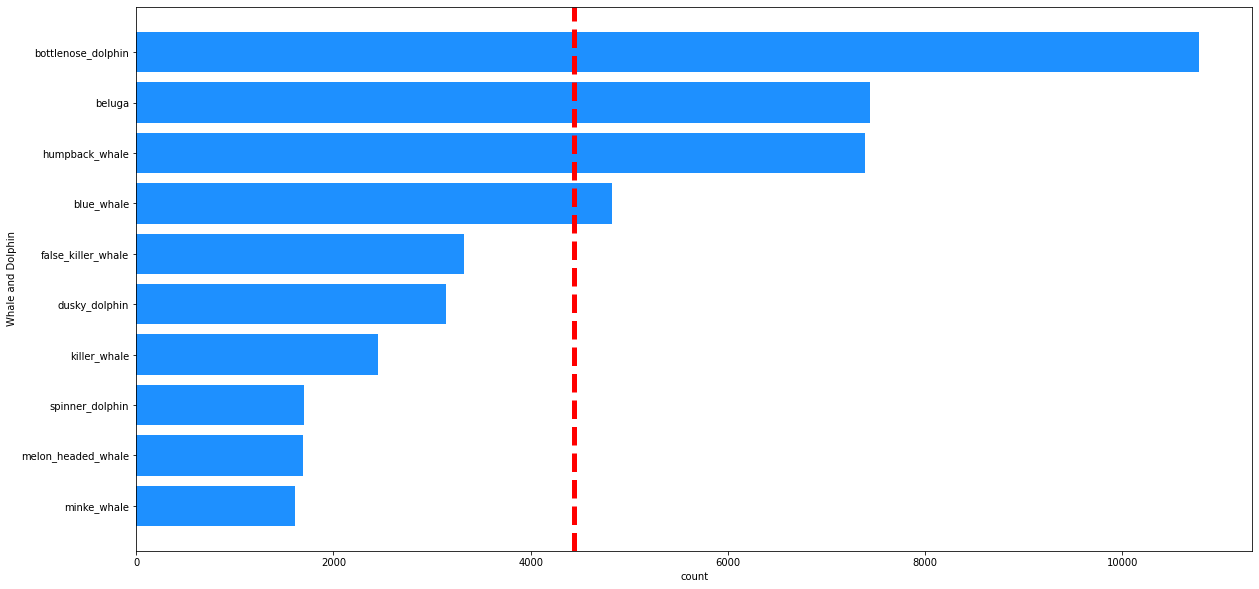

In [8]:
import matplotlib.pyplot as plt
import numpy as np
array = train_df['species'].value_counts().head(10)[::-1]
tmp = array.index.tolist()
count = array.values.tolist()
y = np.arange(10)
plt.figure(figsize = (20, 10))
plt.barh(y, count, color='dodgerblue')
plt.axvline(np.mean(count), ls = '--', color = 'r', linewidth = 5)
plt.yticks(y, tmp)
plt.xlabel('count')
plt.ylabel('Whale and Dolphin')
plt.show()

In [9]:
train_jpg_directory = '../input/happy-whale-and-dolphin/train_images'
test_jpg_directory = '../input/happy-whale-and-dolphin/test_images'

def getImagesPaths(directory):
    images_names = []
    for dirname, _, filenames in os.walk(directory):
        for filename in filenames:
            fullpath = os.path.join(dirname, filename)
            images_names.append(fullpath)
    return images_names

train_jpg = getImagesPaths(train_jpg_directory)
test_jpg = getImagesPaths(test_jpg_directory)

def image_directory(df):
    df['image_dir'] = train_jpg_directory + '/'+ df['image']
    
    return df

train_df = image_directory(train_df)
print('Train Images : ', len(train_jpg))
print('Test Images : ', len(test_jpg))

Train Images :  51033
Test Images :  27956


In [10]:
def display_img(images_path, rows, cols, title):
    figure, ax = plt.subplots(nrows= rows, ncols=cols, figsize = (16, 8))
    plt.suptitle(title, fontsize = 20)
    for ind, image_path in enumerate(images_path):
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        try:
            ax.ravel()[ind].imshow(image)
            ax.ravel()[ind].set_axis_off()
        except:
            continue
    plt.tight_layout()
    plt.show()

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:skyblue; border:0' role="tab" aria-controls="home">
<center>load Image and Visualization Whale & Dolphin</center></h3>

# 6. load Image and Visualization Whale & Dolphin

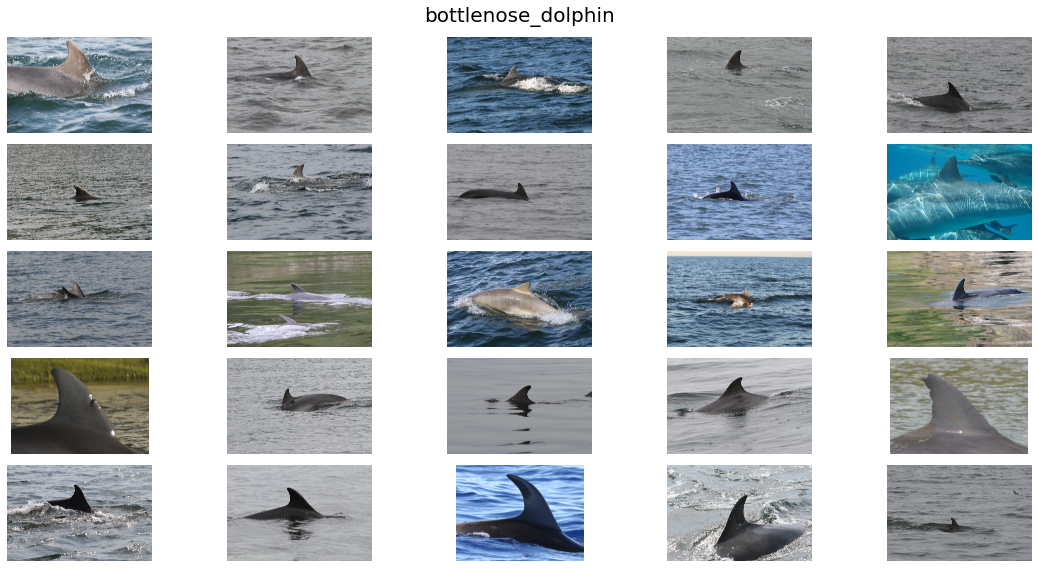

In [11]:
display_img(train_df.loc[train_df['species']=='bottlenose_dolphin']['image_dir'][:25], 5, 5, 'bottlenose_dolphin')

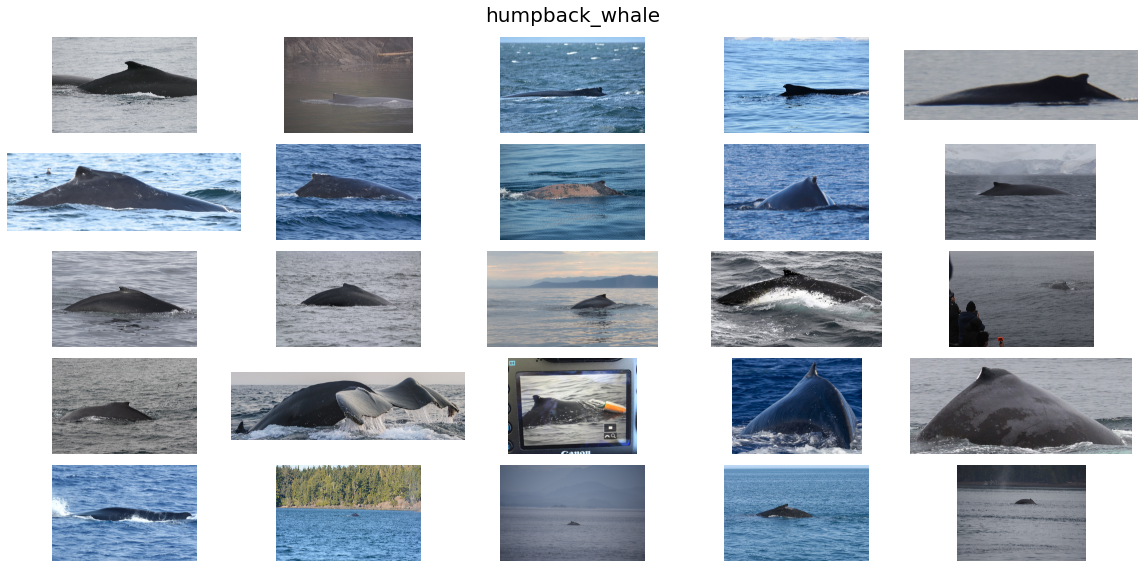

In [12]:
display_img(train_df.loc[train_df['species']=='humpback_whale']['image_dir'][:25], 5, 5, 'humpback_whale')

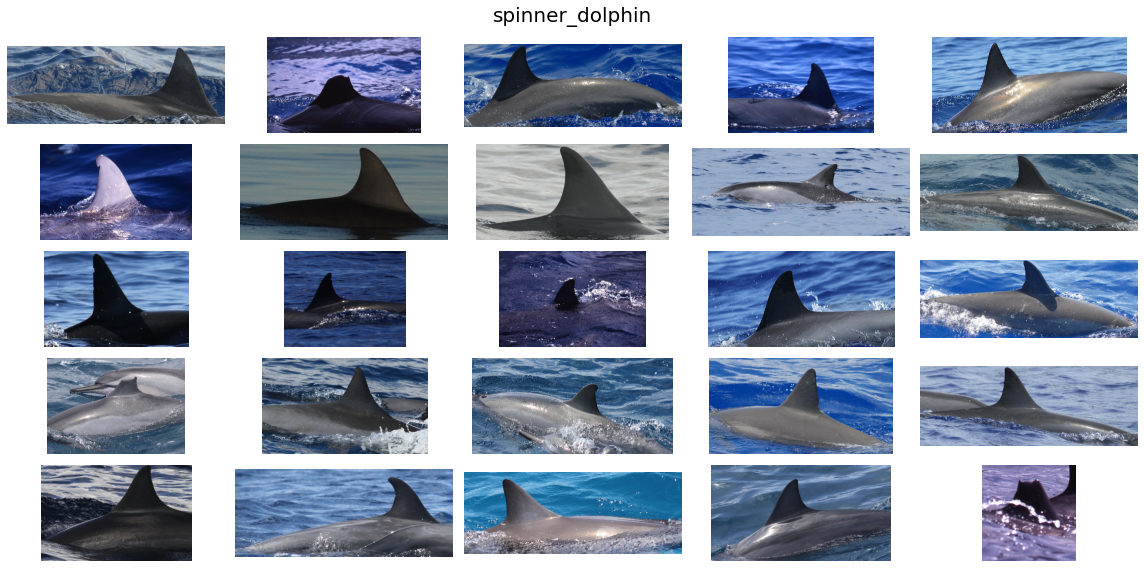

In [13]:
display_img(train_df.loc[train_df['species']=='spinner_dolphin']['image_dir'][:25], 5, 5, 'spinner_dolphin')

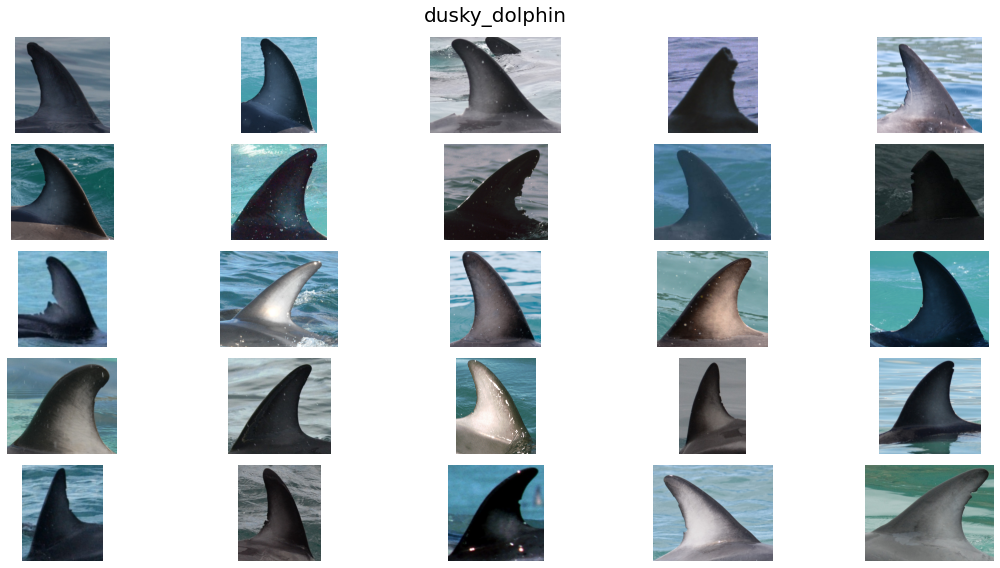

In [14]:
display_img(train_df.loc[train_df['species']=='dusky_dolphin']['image_dir'][:25], 5, 5, 'dusky_dolphin')

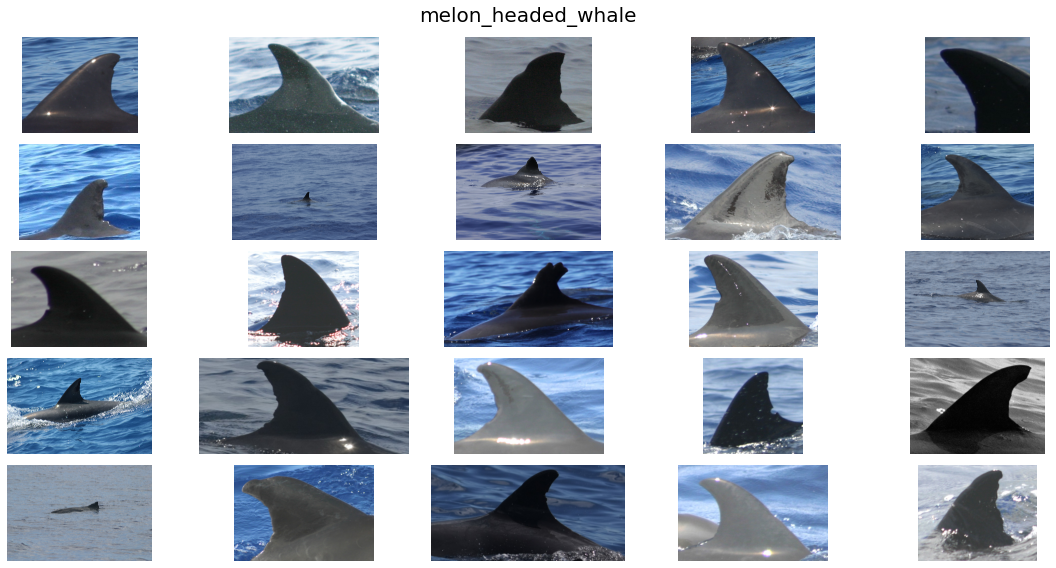

In [15]:
display_img(train_df.loc[train_df['species']=='melon_headed_whale']['image_dir'][:25], 5, 5, 'melon_headed_whale')

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:skyblue; border:0' role="tab" aria-controls="home">
<center>Prepare labeling and Transforms</center></h3>

# 7. Prepare labeling and Transforms

In [16]:
def prepare_labeling(y):
    values = np.array(y)
    label_encoder = LabelEncoder()
    integer_encoded = label_encoder.fit_transform(values)
    onehot_encoder = OneHotEncoder(sparse = False)
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1)
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded)
    y = onehot_encoded
    
    return y, label_encoder

target, label_encoder = prepare_labeling(train_df['individual_id'])
unique_individual_ids = train_df['individual_id'].unique()
NUM_classes = train_df['individual_id'].nunique()
# train_df = train_df.drop('individual_id', axis = 1)

In [17]:
train_transforms = transforms.Compose([transforms.ToPILImage(),
                                       transforms.Resize((56,56)),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.5,0.5,0.5],
                                                            [0.5,0.5,0.5])])

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:skyblue; border:0' role="tab" aria-controls="home">
<center>Load Dataset</center></h3>

# 8. Load Dataset

In [18]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, df, label_to_id, transform):
        self.root_dir = root_dir
        self.df = df
        self.label_to_id = label_to_id
        self.transform = transform
    
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        image_path = os.path.join(self.root_dir, self.df.iloc[index, 0])
        image = cv2.imread(image_path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        label = self.df.iloc[index, 2]
        target = self.label_to_id[label]
        
        image = self.transform(image)
        return image, torch.tensor(target)

In [19]:
label_to_id = {}
id_to_label = {}
idx = 0
for label in unique_individual_ids:
    label_to_id[label] = idx
    id_to_label[idx] = label
    idx += 1

In [20]:
root_dir = '../input/happy-whale-and-dolphin/train_images'

dataset = CustomDataset(root_dir,
                        train_df,
                        label_to_id,
                        train_transforms)

train_loader = DataLoader(dataset, batch_size=8, shuffle=True)

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:skyblue; border:0' role="tab" aria-controls="home">
<center>Model</center></h3>

# 9. Model

In [21]:
model = vgg16(pretrained=True)

model.classifier = nn.Sequential(
    nn.Linear(25088, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, len(label_to_id))
)

for name, param in model.named_parameters():
    if 'classifier' not in name:
        param.requires_grad = False
        
images, targets = next(iter(train_loader))
images.shape, targets.shape        

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

(torch.Size([8, 3, 56, 56]), torch.Size([8]))

In [22]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# model.to(device)
# EPOCHS = 3
# criterion = nn.CrossEntropyLoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# last_train_loss = 0

# for epoch in range(EPOCHS):
#     print(f'Epoch: {epoch+1}/{EPOCHS}')
    
#     correct = 0
#     total = 0
#     losses = []
    
#     for batch_idx, data in enumerate(tqdm(train_loader)):
#         images, targets = data
#         images = images.to(device)
#         targets = targets.to(device)
        
#         output = model(images)  # (batch_size, num_classes)
        
#         loss = criterion(output, targets)
        
#         optimizer.zero_grad()
#         loss.backward()
#         optimizer.step()
        
#         _, pred = torch.max(output, 1)
#         correct += (pred == targets).sum().item()
#         total += pred.size(0)
        
#         losses.append(loss.item())
        
#     train_loss = np.mean(losses)
#     train_acc = correct * 1.0 / total
    
#     last_train_loss = train_loss
#     print(f'Train Loss: {train_loss}\tTrain Acc: {train_acc}')
    
# torch.save({
#     'epoch': EPOCHS,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'loss': last_train_loss
# }, 'last_checkpoint.pth.tar')    

In [23]:
# torch.save({
#     'epoch': EPOCHS,
#     'model_state_dict': model.state_dict(),
#     'optimizer_state_dict': optimizer.state_dict(),
#     'loss': last_train_loss
# }, 'last_checkpoint.pth.tar')

<a id="top"></a>
<div class="list-group" id="list-tab" role="tablist">
<h3 class="list-group-item list-group-item-action active" data-toggle="list" style='color:white; background:skyblue; border:0' role="tab" aria-controls="home">
<center>Conclusion and Submission</center></h3>

# 10. Conclusion and Submission
<br>
It's take lot of time. I hope turn on gpu.

In [24]:
# sample_df = pd.read_csv('../input/happy-whale-and-dolphin/sample_submission.csv')
# sample_df.head()

In [25]:
# test_transforms = transforms.Compose([transforms.ToPILImage(),
#                                      transforms.Resize(56),
#                                      transforms.ToTensor(),
#                                      transforms.Normalize([0.5,0.5,0.5],
#                                                           [0.5,0.5,0.5])])

In [26]:
# test_img_dir = '../input/happy-whale-and-dolphin/test_images'

# res = []

# for i in tqdm(range(sample_df.shape[0])):
#     image_path = os.path.join(test_img_dir, sample_df.iloc[i,0])
#     image = cv2.imread(image_path, cv2.IMREAD_COLOR)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
#     image = test_transforms(image)
#     image = image.unsqueeze(0)

#     output = model(image.to(device))
#     _, tk = torch.topk(output, 5, dim=1)
#     pred = []
#     for j in range(len(tk[0])):
#         pred.append(id_to_label[tk[0][j].item()])
#     pred = ' '.join(pred)
    
#     sample_df.iloc[i, 1] = pred
    
# sample_df.to_csv('submission.csv', index=False)    

# 11. Reference Link
- https://www.kaggle.com/palash97/happywhale-pytorch-vgg16-starter
- https://www.kaggle.com/ruchi798/and-identification-eda-augmentation

# 12. Don't Forget Upvote!